In [139]:
%load_ext autoreload
%autoreload 2
from capuchin import compute_accuracy, model_selection, plot_model_selection, plot_weights

import os, requests
import numpy as np

from scipy.stats import zscore
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
datapath = '/home/droumis/data/Steinmetz-2019/npz/'

fname = []
for j in range(3):
  fname.append(f'{datapath}steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load(f'{datapath}steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [137]:
session = 7
dat = alldat[session]

area_idx = {}
area_idx['VISp'] =  np.where([dat['brain_area'] == 'VISp'])[1]
area_idx['ILA'] =  np.where([dat['brain_area'] == 'ILA'])[1]
area_idx['PLA'] =  np.where([dat['brain_area'] == 'PL'])[1]
area_idx['CA1'] =  np.where([dat['brain_area'] == 'CA1'])[1]
area_idx['MOs'] =  np.where([dat['brain_area'] == 'MOs'])[1]

In [171]:
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10)
y = is_correct

In [119]:
# X = np.reshape(np.transpose(dat['spks'], (1,2,0))[:,:90,0:20],(250,-1))

In [140]:
area = 'ILA'

# PCA

In [179]:
n_pcs = 1
sesh = 7
NN = len(area_idx[area])
NT = NT = dat['spks'][:,:,:90].shape[-1]

In [180]:
droll = np.reshape(dat['spks'][area_idx[area],:,0:90], (NN,-1)) # cat trials
droll = droll - np.mean(droll, axis=1)[:, np.newaxis] # zero centered
model = PCA(n_components = n_pcs).fit(droll.T) # PCA fit times x neurons
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'][area_idx[area],:,0:90], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (n_pcs, -1, 90))

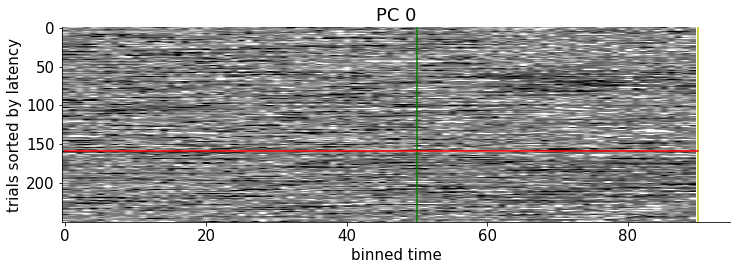

In [181]:
nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])  
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  plt.axvline(50, c='g')
  plt.axvline(90, c='y')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')
plt.savefig(f'/home/droumis/Src/capuchin/figures/PCA_prestimANDstim_5PC_sesh{sesh}.png')
plt.show()

In [145]:
# plt.imshow(X)

In [121]:
y.shape

(250,)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(175, 1800)
(75, 1800)


In [123]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [124]:
pred_train_lr= lr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lr)))
print(r2_score(y_train, pred_train_lr))

pred_test_lr= lr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lr))) 
print(r2_score(y_test, pred_test_lr))

1.5750416644939581e-15
1.0
0.5282925519979691
-0.17683526258842885


In [125]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.0001345984390479841
0.9999999213683168
0.5289436302324015
-0.17973776034055677


In [126]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

0.30988190567188423
0.5832170335814298
0.5558759701033057
-0.30293424252465373


In [127]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

0.1974180892596322
0.8308424393796696
0.5793569026788914
-0.41533442004081067


In [86]:
l = LogisticRegression(penalty='l2', C=.01)

In [87]:
f = l.fit(X,y)

In [88]:
d = f.predict(X)

In [89]:
np.mean(d == is_correct)

0.632

In [13]:
accuracies = cross_val_score(LogisticRegression(penalty='l1'), X, y, cv=8)

/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


In [ ]:
alldatz = np.nan_to_num(zscore(dat['spks'][:,:,:],0))

In [ ]:
X = np.mean(np.squeeze(alldatz[unit_idx_area,:,t:e]),-1).T
alldatz = np.nan_to_num(zscore(dat['spks'][:,:,:],0))